# Gaussian Process Regression

This notebook, I will go over how we can implement the Gaussian process (GP) regression algorithm using Jax. This isn't a new algorithm or anything but I would like to get accustomed to using Jax because it will be useful later when I implement the GPs to handle uncertain inputs.

**Inspirations**

* [Github Code](https://github.com/lucasrm25/Structured-Learning-for-Robot-Control/blob/master/GP/jaxGP.py) - [Lucas](https://www.linkedin.com/in/lucas-rath/?originalSubdomain=bo)
> Broke down the GP function very nicely. Nice enough for me to follow.

## Imports

In [1]:
import functools

import jax
import jax.numpy as jnp
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
plt.style.use(['seaborn-paper'])

## Data

In [97]:
def get_data(n_points=100):
    rng = np.random.RandomState(0)

    # Generate sample data
    X = 15 * rng.rand(100, 1)
    y = np.sin(X).ravel()
    y += 3 * (0.5 - rng.rand(X.shape[0]))  # add noise
    return X, y

(100, 1) (100,)


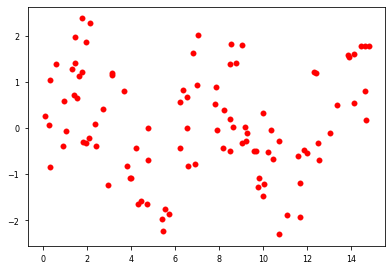

In [98]:
X, y = get_data()
print(X.shape, y.shape)

fig, ax = plt.subplots()
ax.scatter(X, y, c='red')
plt.show()

## Gaussian Process

## Model: GP Prior

**Parameters**:

* X, Y, $\theta= $ (Likelihood Parameters, Kernel Parameters)

1. Compute the Kernel Matrix
2. Compute the Mean function
3. Sample from the Multivariate Normal Distribution

### Kernel Function

$$k(x,y) = \sigma_f \exp \left( - \frac{1}{2\sigma_\lambda^2}|| x - y||^2_2 \right)$$

In [139]:
# Squared Euclidean Distance Formula
@jax.jit
def sqeuclidean_distance(x, y):

    return jnp.sum( (x - y) ** 2)

# RBF Kernel
@jax.jit
def rbf_kernel(params, x, y):
    
    # return the rbf kernel
    return params['var_f'] * jnp.exp( - params['length_scale'] * jnp.sum( (x - y) ** 2) )

# ARD Kernel
@jax.jit
def ard_kernel(params, x, y):
    
    # divide by the length scale
    x = x / params['length_scale']
    y = y / params['length_scale']
    
    # return the ard kernel
    return params['var_f'] * jnp.exp( - jnp.sum( (x - y) ** 2) )



In [133]:
X.shape

(100, 1)

In [136]:
params = {
    'var_f': 1.0,
    'sigma': 1.0
}



### Kernel Matrix

We defined all of our functions above with only dimensions in mind, not the number of samples or the batch size. So we need to account for that. So if we wanted to calculate the kernel matrix, we would have to loop through all of the samples and calculate the products individually, which would take a long time; especially for large amounts of data. 

> Avoid Loops at all cost in python...

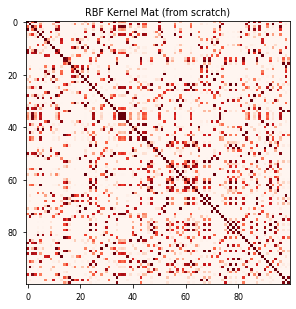

In [137]:
# initialize kernel matrix (with numpy because of indexing)
rbf_kernel_matrix = np.empty(shape=(X.shape[0], X.shape[0]))

# Loop through the data
for i, ix in enumerate(X):
    for j, jx in enumerate(X):
        rbf_kernel_matrix[i, j] = rbf_kernel(params, ix, jx)
        
        
plt.figure()
plt.imshow(rbf_kernel_matrix, cmap="Reds")
plt.title('RBF Kernel Mat (from scratch)')
plt.tight_layout()
plt.show()

In [121]:
from sklearn.gaussian_process.kernels import RBF

In [122]:
K_sk = RBF(1.0)(np.array(X))

# testing
np.testing.assert_array_almost_equal(K_sk, rbf_kernel_matrix)

AssertionError: 
Arrays are not almost equal to 6 decimals

x and y nan location mismatch:
 x: array([[1.000000e+00, 4.441827e-02, 7.207656e-01, ..., 2.201343e-14,
        1.465751e-04, 3.426462e-15],
       [4.441827e-02, 1.000000e+00, 2.412418e-01, ..., 2.481677e-24,...
 y: array([[ 6.935215e-310,  6.935215e-310,  6.935256e-310, ...,
        -2.625497e-301, -3.092136e-301, -3.558775e-301],
       [-4.317774e-301, -5.251052e-301, -6.184329e-301, ...,...

In [123]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

Fortunately, Jax has this incredible function `vmap` which handles batching automatically at apparently, no extra cost. So we can write our functions to account for vectors without having to care about the batch size and then use the `vmap` function to essentially "vectorize" our functions. It essentially allows us to take a product between a matrix and a sample or two vectors of multiple samples. Let's go through an example of how we can construct our kernel matrix.

1. We need to map all points with one vector to another.

We're going to take a single sample from $X'$ and take the rbf kernel between it and all of $X$. So:

$$\text{vmap}_f(\mathbf{X}, \mathbf{x})$$

where $X\in \mathbb{R}^{N \times D}$ is a matrix and $\mathbf{x} \in \mathbb{R}^{D}$ is a vector.

In [10]:
# map function 1
mapx1 = jax.vmap(lambda x, y: rbf_kernel(params, x, y), in_axes=(0, None), out_axes=0)

# test the mapping
x1_mapped = mapx1(X, X[0, :])

# Check output shapes, # of dimensions
assert x1_mapped.shape[0] == X.shape[0]   
assert jnp.ndim(x1_mapped) == 1           

This that's good: we have an array of size $N$. So we've effectively mapped all points from one array to the other. 

So now we can do another vector mapping which allows us to take all samples of $X'$ and map them against all samples of $X$. So it'll be a `vmap` of a `vmap`. Then we'll get the $N\times N$ kernel matrix.

In [11]:
mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)

K = mapx2(X, X)

# Check output shapes, # of dimensions
assert K.shape[0] == X.shape[0], X.shape[0]   
assert jnp.ndim(K) == 2     

So great! We now have our kernel matrix. Let's plot it and check to see if it matches the manually constructed kernel matrix.

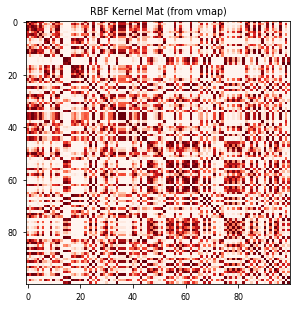

In [12]:
plt.figure()
plt.imshow(K, cmap='Reds')
plt.title('RBF Kernel Mat (from vmap)')
plt.tight_layout()
plt.show()

# Testing
np.testing.assert_array_equal(np.array(K), rbf_kernel_matrix)

Great! We have a vectorized kernel function and we were still able to construct our functions in terms of vectors only! This is nice for me personally because I've always struggled with understanding some of the coding when trying to deal with samples/batch-sizes. Most pseudo-code is written in vector format so paper $\rightarrow$ has always been a painful transition for me. So now, let's wrap this in a nice function so that we can finish "wrap up" this model.

In [138]:
def covariance_matrix(kernel_func, params, x, y):
    mapx1 = jax.vmap(lambda x, y: kernel_func(params, x, y), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)
    return mapx2(x, y)

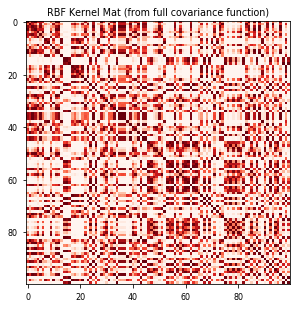

In [14]:
# construct kernel
K_ = covariance_matrix(rbf_kernel, params, X, X)

# Check output shapes, # of dimensions
assert K.shape[0] == X.shape[0], X.shape[0]   
assert jnp.ndim(K) == 2  

# plot
plt.figure()
plt.imshow(K_, cmap='Reds')
plt.title('RBF Kernel Mat (from full covariance function)')
plt.tight_layout()
plt.show()

# Testing
np.testing.assert_array_equal(np.array(K), np.array(K_))

### Mean Function

Honestly, I never work with mean functions. I always assume a zero-mean function and that's it. I don't really know anyone who works with mean functions either. I've seen it used in deep Gaussian processes but I have no expertise in which mean functions to use. So, we'll follow the community standard for now: zero mean function

In [6]:
def zero_mean(x):
    return jnp.zeros(x.shape[0])

### 3. Compute Model

Now we have all of the components to make our GP prior function.

In [7]:
def gp_prior(params, mu_f, cov_f, x):
    return mu_f(x) , cov_f(params, x, x)

In [17]:
# define the parameters
params = {
    'length_scale': 1.0,
    'var_f': 1.0
}

# define mean function
mu_f = zero_mean

# define covariance function
params = {
    'length_scale': 1.0,
    'var_f': 1.0
}
cov_f = functools.partial(covariance_matrix, rbf_kernel)

mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f, x=X[0, :])



#### Checks

So I'm still getting used to the `vmap`. So in theory, this function should work for a vector $\mathbf{x} \in \mathbb{R}^{D}$ and for a batch of samples $X \in \mathbb{R}^{N \times D}$

In [18]:
# checks - 1 vector (D)
test_X = X[0, :].copy()
mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f, x=test_X) 

print(mu_x.shape, cov_x.shape)
assert mu_x.shape[0] == test_X.shape[0]
assert jnp.ndim(mu_x) == 1
# Check output shapes, # of dimensions
assert cov_x.shape[0] == test_X.shape[0]
assert jnp.ndim(cov_x) == 2 


# checks - 1 vector with batch size (NxD)
test_X = X.copy()
mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f, x=test_X) 


assert mu_x.shape[0] == test_X.shape[0]
assert jnp.ndim(mu_x) == 1
# Check output shapes, # of dimensions
assert cov_x.shape[0] == test_X.shape[0]
assert jnp.ndim(cov_x) == 2

(1,) (1, 1)


Woot! Success! So now we can technically sample from this GP prior distribution.

### 4. Sampling from GP Prior

In [57]:
from scipy.stats import multivariate_normal as scio_mvn

In [ ]:
stats.norm()

#### Scipy

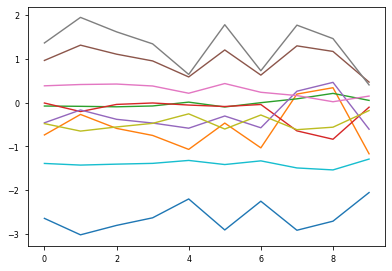

In [59]:
# checks - 1 vector (D)
params = {
    'length_scale': 0.1, 
    'var_f': 1.0, 
}


n_samples = 10                   # condition on 3 samples 
test_X = X[:n_samples, :].copy() # random samples from distribution

mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f , x=test_X)

# check outputs
assert mu_x.shape == (n_samples,)
assert cov_x.shape == (n_samples, n_samples)

# draw random samples from distribution
n_functions = 10
y_samples = stats.multivariate_normal.rvs(mean=mu_x, cov=cov_x, size=n_functions)

assert y_samples.shape == (n_functions, n_samples)

for isample in y_samples:
    plt.plot(isample)

#### Note - The positive semi-definite error

I believe that's due to the diagonals being off. Normally we add something called jitter. This allows the matrix to be positive semi-definite.

(10, 10)


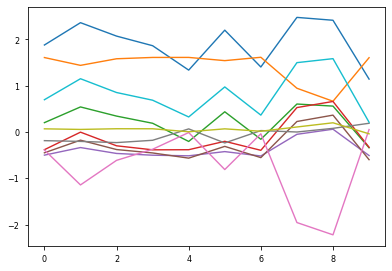

In [21]:
mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f , x=test_X)

# make it semi-positive definite with jitter
jitter = 1e-6
cov_x_ = cov_x + jitter * np.eye(cov_x.shape[0])

# draw random samples from distribution
n_functions = 10
y_samples = scio_mvn.rvs(mean=mu_x, cov=cov_x_ , size=n_functions)

print(y_samples.shape)
for isample in y_samples:
    plt.plot(isample)

And now we don't have that message. This is a small thing but it's super important and can lead to errors in the optimization if not addressed.

#### Jax

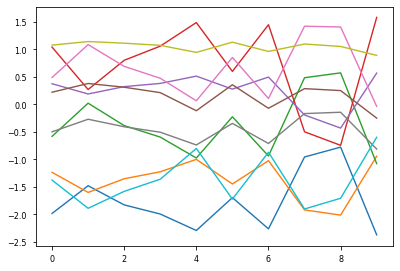

In [22]:
# checks - 1 vector (D)
params = {
    'length_scale': 0.1, 
    'var_f': 1.0, 
}


n_samples = 10                   # condition on 3 samples 
test_X = X[:n_samples, :].copy() # random samples from distribution

mu_x, cov_x = gp_prior(params, mu_f=mu_f, cov_f=cov_f , x=test_X)

# make it semi-positive definite with jitter
jitter = 1e-6
cov_x_ = cov_x + jitter * jnp.eye(cov_x.shape[0])


n_functions = 10

key = jax.random.PRNGKey(0)

y_samples = jax.random.multivariate_normal(key, mu_x, cov_x_, shape=(n_functions,))

# check
assert y_samples.shape == (n_functions, n_samples)

for isample in y_samples:
    plt.plot(isample)

## 4. Posterior

Conditioned on the observations, can we make predictions.

In [8]:
def gp_prior(params, mu_f, cov_f, x):
    return mu_f(x) , cov_f(params, x, x)

@jax.jit
def cholesky_factorization(K, Y):
    
    # cho factor the cholesky 
    L = jax.scipy.linalg.cho_factor(K)

    # weights
    weights = jax.scipy.linalg.cho_solve(L, Y)
    
    return L, weights

jitter = 1e-6

def posterior(params, gp_priors, X, Y, X_new):
    
    (mu_func, cov_func) = gp_priors
    
    # ==========================
    # 1. GP PRIOR
    # ==========================
    mu_x, Kxx = gp_prior(params, mu_f=mu_func, cov_f=cov_func , x=X)
    
    # check outputs
    assert mu_x.shape == (X.shape[0],), f"{mu_x.shape} =/= {(X.shape[0],)}"
    assert Kxx.shape == (X.shape[0],X.shape[0]),  f"{Kxx.shape} =/= {(X.shape[0],X.shape[0])}"
    
    # ===========================
    # 2. CHOLESKY FACTORIZATION
    # ===========================
    
    # 1 STEP
    print(f"Problem: {Kxx.shape},{Y.shape}")
    (L, lower), alpha = cholesky_factorization(Kxx + ( params['likelihood_noise'] + 1e-6 ) * jnp.eye(Kxx.shape[0]), Y)
    
    assert L.shape == (X.shape[0],X.shape[0]),  f"L:{L.shape} =/= X..:{(X.shape[0],X.shape[0])}"
    assert alpha.shape == (X.shape[0],), f"alpha: {alpha.shape} =/= X: {X.shape[0]}"
    
    # ================================
    # 4. PREDICTIVE MEAN DISTRIBUTION
    # ================================
    
    # calculate transform kernel
    KxX = cov_f(params, X_new, X)
    assert KxX.shape == (X_new.shape[0],X.shape[0]),  f"{KxX.shape} =/= {(X.shape[0],X_new.shape[0])}"
    
    # Project data
    mu_y = mu_func(X_new) + jnp.dot(KxX, alpha)
    
    assert mu_y.shape == X_new.shape
    
#     # =====================================
#     # 5. PREDICTIVE COVARIANCE DISTRIBUTION
#     # =====================================
# #     print(f"K_xX: {KXx.T.shape}, L: {L.shape}")
#     print(f"L: {L.shape}, KxX: {KxX.shape}", lower)
#     v = jax.scipy.linalg.cho_solve((L, lower), KxX.T)
#     print(f"v:", v.shape)
    
#     assert v.shape == (X.shape[0], X_new.shape[0],), f"v: {v.shape} =/= {(X_new.shape[0])}"
    
#     cov_y = cov_func(params, X_new, X_new)
    
#     assert cov_y.shape == (X_new.shape[0], X_new.shape[0])
    
#     cov_y = cov_y - jnp.dot( KxX, v)
    
#     assert cov_y.shape == (X_new.shape[0], X_new.shape[0])
    
#     # TODO: Bug here for vmap...
    
    # =====================================
    # 6. PREDICTIVE VARIANCE DISTRIBUTION
    # =====================================
    
    Linv = jax.scipy.linalg.solve_triangular(L.T, jnp.eye(L.shape[0]))
    
    var_y = jnp.diag(cov_func(params, X_new, X_new))
    
    var_y = var_y + jnp.einsum("ij, jk, ki->i", KxX, jnp.dot(Linv, Linv.T), KxX.T)
    
    return mu_y, var_y

In [144]:
# MEAN FUNCTION
mu_f = zero_mean

# COVARIANCE FUNCTION
params = {
    'length_scale': 1.0,
    'var_f': 1.0,
    'likelihood_noise': 0.01,
}
cov_f = functools.partial(covariance_matrix, rbf_kernel)

# input vector
x_plot = jnp.linspace(X.min(), X.max(), 100)[:, None]
test_X = x_plot[0, :]

prior_funcs = (mu_f, cov_f)
# print(X.shape, y.shape, test_X.shape)
mu_y, var_y = posterior(params, prior_funcs, X, y, X_new=test_X)

print(mu_y.shape, var_y.shape)

Problem: (100, 100),(100,)
(1,) (1,)


In [43]:

test_X = x_plot.copy()

# posterior_map = functools.partial(posterior, )
mu_y, var_y = jax.vmap(posterior, in_axes=(None, None, None, None, 0), out_axes=(0, 0))(params, prior_funcs, X, y, test_X)

print(mu_y.shape, var_y.shape)

(100, 1) (100, 1)


In [44]:
mu_y.shape, cov_y.shape

((100, 1), (100, 1, 1))

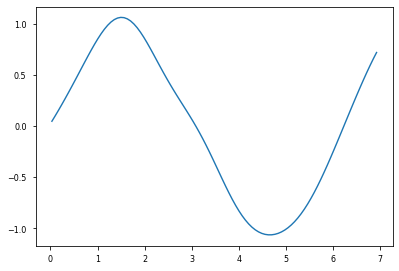

In [45]:
uncertainty = 1.96 * jnp.sqrt(var_y.squeeze())

# plt.fill_between(test_X.squeeze(), mu_y.squeeze() + uncertainty, mu_y.squeeze() - uncertainty, alpha=0.1)
plt.plot(test_X, mu_y, label='Mean')

## 5. Loss - Log-Likelihood

### From Scratch

In [233]:

# @jax.jit
def cholesky_factorization(K, Y):
    
    # cho factor the cholesky 
    L = jax.scipy.linalg.cho_factor(K)

    # weights
    weights = jax.scipy.linalg.cho_solve(L, Y)
    
    return L, weights

def nll_scratch(params, gp_priors, X, Y) -> float:
    
    (mu_func, cov_func) = gp_priors
    
    # ==========================
    # 1. GP PRIOR
    # ==========================
    mu_x, Kxx = gp_prior(params, mu_f=mu_func, cov_f=cov_func , x=X)
    print(mu_x.shape, Kxx.shape)
    
    # ===========================
    # 2. CHOLESKY FACTORIZATION
    # ===========================
#     print(f"Problem:", X.shape, Y.shape, Kxx.shape)
#     print(f"Y: {Y.shape}, Kxx: {Kxx.shape}")
    (L, lower), alpha = cholesky_factorization(Kxx + ( params['likelihood_noise'] + 1e-6 ) * jnp.eye(Kxx.shape[0]), Y)
    print(f"Y: {Y.shape}, alpha: {alpha.shape}")
    log_likelihood_dims = -0.5 * jnp.einsum("i,i->", Y, alpha)
    log_likelihood_dims -= jnp.sum(jnp.log(jnp.diag(L)))
    log_likelihood_dims -= ( Kxx.shape[0] / 2 ) * jnp.log(2 * jnp.pi)
    
    return log_likelihood_dims
# #     print(L.shape, alpha.shape)
#     # cho factor the cholesky 
#     K_gp = Kxx + ( params['likelihood_noise'] + 1e-6 ) * jnp.eye(Kxx.shape[0])
# #     L = jax.scipy.linalg.cholesky(K_gp)
# #     assert np.testing.assert_array_almost_equal(K_gp, L @ L.T), 
    
#     return jax.scipy.stats.multivariate_normal.logpdf(Y, mean=mu_x, cov=K_gp)

In [235]:
# MEAN FUNCTION
mu_f = zero_mean

# COVARIANCE FUNCTION
params = {
    'length_scale': 1.0,
    'var_f': 1.0,
    'likelihood_noise': 0.01,
}
cov_f = functools.partial(covariance_matrix, rbf_kernel)

# input vector
x_plot = jnp.linspace(X.min(), X.max(), 100)[:, None]
test_X = x_plot[0, :]

prior_funcs = (mu_f, cov_f)
# print(X.shape, y.shape, test_X.shape)

nll = nll_scratch(params, prior_funcs, X[0,:], y[0, None])
print(nll)

(1,) (1, 1)
Y: (1,), alpha: (1,)
-1.2585021


#### Auto-Batching with VMAP

In [234]:
nll_scratch_vec = jax.vmap(nll_scratch, in_axes=(None, None, 0, 0))

nll = nll_scratch_vec(params, prior_funcs, X, y[:, None])
print(nll.sum())


(1,) (1, 1)
Y: (1,), alpha: (1,)
-209.98637


### Refactor - Built-in Function

It turns out that the jax library already has the `logpdf` for the `multivariate_normal` already implemented. So we can just use that.

In [9]:
def gp_prior(params, mu_f, cov_f, x):
    return mu_f(x) , cov_f(params, x, x)

def marginal_likelihood(params, prior_funcs, Xtrain, Ytrain):
    
    # unpack params
    (mu_func, cov_func) = prior_funcs
    
    # ==========================
    # 1. GP Prior
    # ==========================
    mu_x = mu_f(Xtrain)
    Kxx = cov_f(params, Xtrain, Xtrain)
#     print("MLL (GPPR):", Xtrain.shape, Ytrain.shape)
#     mu_x, Kxx = gp_prior(params, mu_f=mu_func, cov_f=cov_func , x=Xtrain)
    
    # ===========================
    # 2. GP Likelihood
    # ===========================
    K_gp = Kxx + ( params['likelihood_noise'] + 1e-6 ) * jnp.eye(Kxx.shape[0])
    
#     print("MLL (GPLL):", Xtrain.shape, Ytrain.shape)
    
    # ===========================
    # 3. Built-in GP Likelihood
    # ===========================
    return jax.scipy.stats.multivariate_normal.logpdf(Ytrain, mean=mu_x, cov=K_gp)




In [158]:
nll_ = marginal_likelihood(params, prior_funcs, X[0,:], y[0])
print(nll_)

(1,) (1, 1)
-1.2585021


In [159]:
nll = jax.vmap(marginal_likelihood, in_axes=(None, None, 0, 0))(params, prior_funcs, X, y)

print(nll.shape)
print(nll.sum())

(1,) (1, 1)
(100,)
-121.730606


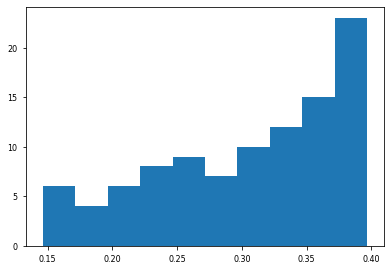

In [160]:
plt.hist(np.exp(nll));

## 6. Training

In [16]:
marginal_likelihood

<function __main__.marginal_likelihood(params, gp_priors, X, Y)>

In [141]:
# MEAN FUNCTION
mu_f = zero_mean

# COVARIANCE FUNCTION
params = {
    'length_scale': jnp.median(X),
    'var_f': 1.0,
    'likelihood_noise': 1e-2,
}
cov_f = functools.partial(covariance_matrix, ard_kernel)

gp_priors = (mu_f, cov_f)

X, y = get_data(10)

# m_ll_vectorized = jax.vmap(marginal_likelihood, in_axes=(None, None, 0, 0))

# define an explicit loss function (with context variables)

# Nice Trick for better training of params
def log_params(params):
    return {ikey:jax.nn.softplus(ivalue) for (ikey, ivalue) in params.items()}

def loss(params, Xtrain, ytrain):
    return - marginal_likelihood(log_params(params), gp_priors, Xtrain, ytrain)

_ = marginal_likelihood(params, gp_priors, X[0,:], y[0].copy())
# print('DONE MLL')


# # SINGLE OUTPUT
# dloss = jax.value_and_grad(loss)
# nll, grads = dloss(params, X[0,:], y[0])

# grad function (BATCH)
dloss = jax.jit(jax.vmap(jax.value_and_grad(loss), in_axes=(None, 0, 0), out_axes=(0, 0)))
# print(y.shape)
nll, grads = dloss(params, X, y)
# print(y.shape)

n_epochs = 2_000
learning_rate = 0.01
losses = list()

import tqdm

# @jax.jit
with tqdm.trange(n_epochs) as bar:
    
    for _ in bar:
        postfix = {}
        # get nll and grads
        nll, grads = dloss(params, X, y)

        # update params
        for ikey in params.keys():
            postfix[ikey] = f"{params[ikey]:.4f} | {grads[ikey].mean():.4f}"
            params[ikey] = params[ikey] - learning_rate * grads[ikey].mean()

        losses.append(nll.sum())
        postfix['Loss'] = np.array(losses[-1])
        bar.set_postfix(postfix)

params = log_params(params)

100%|██████████| 2000/2000 [00:09<00:00, 218.90it/s, length_scale=7.0122 | 0.0000, var_f=0.3200 | 0.0104, likelihood_noise=-0.4500 | 0.0070, Loss=154.79407]


In [142]:
params, grads

({'length_scale': DeviceArray(7.013115, dtype=float32),
  'var_f': DeviceArray(0.86581355, dtype=float32),
  'likelihood_noise': DeviceArray(0.4932109, dtype=float32)},
 {'length_scale': DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
               0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
  'likelihood_noise': DeviceArray([ 0.12672192,  0.13530308,  0.13165155,  0.12310275,
                0.0714516 ,  0.1180307 ,  0.14323828,  0.11607432,
               -0.19094095, -0.22338572,  0.11912844,  0.14304906,
                0.13953568, -0.11846319,  0.14277449, -0.02832298,
     

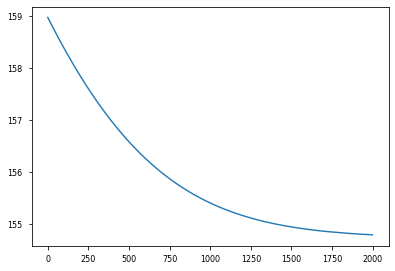

In [143]:
plt.plot(losses)

## 7. Predictions

In [114]:
# print(X.shape, y.shape, test_X.shape)
x_plot = jnp.linspace(X.min(), X.max(), 1_000)[:, None]
print(X.shape, y.shape)
mu_y, var_y = posterior(params, gp_priors, X, y, X_new=x_plot[0, :])

print(mu_y.shape, var_y.shape)

(100, 1) (100,)
Problem: (100, 100),(100,)
(1,) (1,)


In [115]:
# input vector
# x_plot = jnp.linspace(X.min(), X.max(), 100)[:, None]
# test_X = x_plot[0, :]

# posterior_map = functools.partial(posterior, )
posterior_vec = jax.vmap(posterior, in_axes=(None, None, None, None, 0), out_axes=(0, 0))
mu_y, var_y = posterior_vec(params, gp_priors, X, y, x_plot)

print(mu_y.shape, var_y.shape)

Problem: (100, 100),(100,)
(1000, 1) (1000, 1)


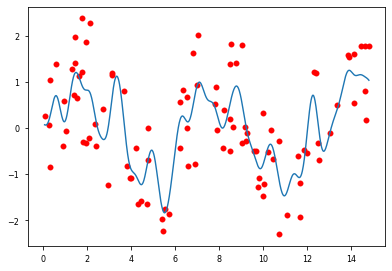

In [116]:
uncertainty = 1.96 * jnp.sqrt(var_y.squeeze())


fig, ax = plt.subplots()
ax.scatter(X, y, c='red')
plt.plot(x_plot, mu_y, label='Mean')
# plt.fill_between(x_plot.squeeze(), mu_y.squeeze() + uncertainty, mu_y.squeeze() - uncertainty, alpha=0.1)
plt.show()